In [1]:
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings('ignore')

import string
import nltk
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from utils import cosine_sim ## This only for testing
from utils import get_upper_triangular_values, threshold_transform

In [2]:
df_isp_irc = pd.read_excel('Data/vt_isp_irc.xlsx')
df_isp_task = pd.read_excel('Data/vt_isp_task_mhrs.xlsx')
df_isp_material = pd.read_excel('Data/vt_isp_material_consumption_pricing.xlsx')

df_isq_irc = pd.read_excel('Data/vt_isq_irc.xlsx')
df_isq_task = pd.read_excel('Data/vt_isq_task_mhrs.xlsx')
df_isq_material = pd.read_excel('Data/vt_isq_material_consumption_pricing.xlsx')

df_iux_irc = pd.read_excel('Data/vt_iux_irc.xlsx')
df_iux_task = pd.read_excel('Data/vt_iux_task_mhrs.xlsx')
df_iux_material = pd.read_excel('Data/vt_iux_material_consumption_pricing.xlsx')

In [3]:
df_isp_irc.head(2)                                                                                                            

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000059/0923/1,53,1. DURING INSPECTION OBERVED LH WING SLATE #01...,1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...,HMV23/000059/0923/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000059/0923/2,34,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...,CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...,HMV23/000059/0923/2,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


### Fields to consider in 'VT ISP IRC'
- Planned Start Date
- Planned End Date
- Actual Start Date
- Actual End Date
- Est. Man Hrs.
- Actual Man Hrs.
- Insp Req?
- Mech Req?
- Part Required?
- Contract Classification
- Source Task/Discrep. #
- Description
- Corrective Action
- Log Item #

In [4]:
df_isq_irc.head(2)

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000055/0923/1,57,"DURING ARRIVAL INSPECTION , OBSERVED DENT ON S...",REFER SDIRC HMV23/000055/0923/7 FOR REPAIR DET...,HMV23/000055/0923/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000055/0923/2,53,DURING INSPECTION OBSERVED LH WING SLAT#5 WEAT...,CARRIED OUT INSTALLATION OF LH WING SLAT #5 OU...,HMV23/000055/0923/2,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


In [5]:
df_iux_irc.head(2)

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000043/0823/1,33,DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV...,1. RH NAV POSITION LIGHT TROUBLESHOOTING CARRI...,HMV23/000043/0823/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000043/0823/2,25,CARRY OUT CA SEATS AND DOOR TRIMS (QTY49) PAIN...,1.FWD AND AFT WALL MOUNTED CABIN ATTENDENT SEA...,HMV23/000043/0823/2,Close,Closed,AWR23/002577/0823,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


### Tokenize and embed the descriptions of unexpected observations made.

In [6]:
# Download NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ranjith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ranjith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ranjith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Load spacy en_core_web_sm model
nlp = spacy.load("en_core_web_sm")

In [8]:
def preprocess_text(text: str, preserve_symbols=[], words_to_remove=['DURING', 'INSPECTION', 'OBSERVED']) -> str:
    '''
    This function performs text preprocessing and returns processed text. 
    It will also accept a list of symbols to preserve.
    Input: text
    Output: text
    '''
    # Define symbols to preserve
    preserve_symbols = set(preserve_symbols)

    for word in words_to_remove:
        text = text.replace(word, ' ')
    
    # Remove punctuation, excluding specified symbols
    custom_translation = str.maketrans('', '', ''.join(set(string.punctuation) - preserve_symbols))
    text = text.translate(custom_translation)
    return text


def tokenization(preprocessed_text: str) -> list:
    '''
    This function performs text tokenization and returns a list of tokens.
    Input: text
    Output: list of tokens
    '''
    sentences = sent_tokenize(preprocessed_text)
    preprocessed_tokens = []

    # Tokenization and stopword removal
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token.lower() not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        preprocessed_tokens.append(tokens)

    return preprocessed_tokens


def calculate_embeddings(preprocessed_tokens: list) -> list:
    '''
    This function performs text embedding and returns a list of embeddings.
    Input: list of tokens
    Output: list of embeddings
    '''
    # Embedding
    embeddings = []
    for token in preprocessed_tokens:
        sentence = ' '.join(token)
        doc = nlp(sentence)
        sentence_embedding = doc.vector
        embeddings.append(sentence_embedding)

    return embeddings


def main(text: str, preserve_symbols=['-', '/']) -> list:
    '''
    This function performs text preprocessing, tokenization, embedding and returns a list of embeddings.
    Input: text
    Output: list of embeddings
    '''
    preprocessed_text = preprocess_text(text, preserve_symbols)
    preprocessed_tokens = tokenization(preprocessed_text)
    embeddings = calculate_embeddings(preprocessed_tokens)

    return embeddings

### ISP

In [9]:
# grouped_df_Description = df_isp_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
# grouped_df_Corrective_Action = df_isp_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
# df_isp_irc['description_correction'] = df_isp_irc['Description'] +' '+df_isp_irc['Corrective Action']
# grouped_df_description_correction = df_isp_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [10]:
# df_isp_irc['description_embedding'] = grouped_df_Description.explode().tolist()
# df_isp_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
# df_isp_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

### ISQ

In [11]:
# grouped_df_Description = df_isq_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
# grouped_df_Corrective_Action = df_isq_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
# df_isq_irc['description_correction'] = df_isq_irc['Description'] +' '+df_isq_irc['Corrective Action']
# grouped_df_description_correction = df_isq_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [12]:
# df_isq_irc['description_embedding'] = grouped_df_Description.explode().tolist()
# df_isq_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
# df_isq_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

### IUX

In [13]:
# grouped_df_Description = df_iux_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
# grouped_df_Corrective_Action = df_iux_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
# df_iux_irc['description_correction'] = df_iux_irc['Description'] +' '+df_iux_irc['Corrective Action']
# grouped_df_description_correction = df_iux_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [14]:
# df_iux_irc['description_embedding'] = grouped_df_Description.explode().tolist()
# df_iux_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
# df_iux_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

### Similarity matrix for Description column

In [15]:
# isp_vec = pd.DataFrame(np.array(df_isp_irc['description_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
# isq_vec = pd.DataFrame(np.array(df_isq_irc['description_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
# iux_vec = pd.DataFrame(np.array(df_iux_irc['description_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [16]:
# df_description = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
# df_description

In [17]:
# cos_sim_description_mat = cosine_similarity(df_description.T)
# cosine_sim_description_df = pd.DataFrame(cos_sim_description_mat, index=df_description.columns, columns=df_description.columns)

In [18]:
# # Heatmap of cosine similarity matrix for description
# sns.heatmap(cosine_sim_description_df, cmap='viridis')
# plt.show()

In [19]:
# cosine_sim_description_df.to_csv('./similarityMatrixFiles/cos_sim_description.csv', index=True)

### Similarity Matrix for "Corrective Measure"

In [20]:
# isp_vec = pd.DataFrame(np.array(df_isp_irc['corrective_action_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
# isq_vec = pd.DataFrame(np.array(df_isq_irc['corrective_action_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
# iux_vec = pd.DataFrame(np.array(df_iux_irc['corrective_action_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [21]:
# df_correction = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
# df_correction

In [22]:
# cos_sim_correction_mat = cosine_similarity(df_correction.T)
# cosine_sim_correction_df = pd.DataFrame(cos_sim_correction_mat, index=df_correction.columns, columns=df_correction.columns)

In [23]:
# cosine_sim_correction_df.to_csv('./similarityMatrixFiles/cos_sim_correction.csv', index=True)

In [24]:
# # Heatmap of cosine similarity matrix for description
# sns.heatmap(cosine_sim_correction_df, cmap='viridis')
# plt.show()

### Similarity Matrix for "Description + Corrective Measure"

In [25]:
# isp_vec = pd.DataFrame(np.array(df_isp_irc['description_correction_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
# isq_vec = pd.DataFrame(np.array(df_isq_irc['description_correction_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
# iux_vec = pd.DataFrame(np.array(df_iux_irc['description_correction_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [26]:
# df_desc_correction = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
# df_desc_correction

In [27]:
# cos_sim_desc_correction_mat = cosine_similarity(df_desc_correction.T)
# cosine_sim_desc_correction_df = pd.DataFrame(cos_sim_desc_correction_mat, index=df_desc_correction.columns, columns=df_desc_correction.columns)

In [28]:
# cosine_sim_desc_correction_df.to_csv('./similarityMatrixFiles/cos_sim_desc_correction.csv', index=True)

In [29]:
# # Heatmap of cosine similarity matrix for description
# sns.heatmap(cosine_sim_desc_correction_df, cmap='viridis')
# plt.show()

## TF-IDF Vectorizer

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def main(corpus: list, preserve_symbols=['-', '/']) -> list:
    # Preprocess text for the entire corpus
    preprocessed_corpus = [preprocess_text(text, preserve_symbols) for text in corpus]
    
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer()
    embeddings = vectorizer.fit_transform(preprocessed_corpus)

    # Convert the sparse matrix to dense array
    dense_embeddings = embeddings.toarray()

    return dense_embeddings, vectorizer

### Description

In [31]:
df_final_description = pd.concat([
    df_isp_irc[['Log Item #', 'Description']],
    df_isq_irc[['Log Item #', 'Description']],
    df_iux_irc[['Log Item #', 'Description']]], axis=0).copy()

In [32]:
# df_final_description['description_embeddings'] = df_final_description['Description'].apply(lambda x: main(x, preserve_symbols=['-', '/']))
desc_tf_idf_vec, vectorizer = main(df_final_description['Description'].tolist(), preserve_symbols=['-', '/'])

In [33]:
desc_tf_idf_vec.shape

(62, 453)

In [34]:
description_embeddings = pd.DataFrame(desc_tf_idf_vec, index=df_final_description['Log Item #'].tolist())
description_embeddings = description_embeddings.T

In [35]:
description_embeddings

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.230108,0.000000,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.212053,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.192732,0.00000,0.000000,0.222822,0.000000,0.000000,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.272564,0.000000,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
449,0.112706,0.0,0.0,0.0,0.196448,0.0,0.0,0.0,0.0,0.0,...,0.133764,0.097787,0.19068,0.176318,0.113055,0.125691,0.192566,0.0,0.0,0.000000
450,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.248048
451,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [36]:
cos_sim_desc_mat = cosine_similarity(description_embeddings.T)
cosine_sim_desc_df = pd.DataFrame(cos_sim_desc_mat, 
                                  index=description_embeddings.columns, 
                                  columns=description_embeddings.columns)

In [37]:
cosine_sim_desc_df.to_csv('./tfIdfSImMat/cos_sim_desc.csv', index=True)

In [38]:
cosine_sim_desc_df.loc[['HMV23/000055/0923/3', 'HMV23/000055/0923/4', 'HMV23/000055/0923/5'],['HMV23/000055/0923/3', 'HMV23/000055/0923/4', 'HMV23/000055/0923/5']]

,HMV23/000055/0923/3,HMV23/000055/0923/4,HMV23/000055/0923/5
HMV23/000055/0923/3,1.000000,0.521615,0.482420
HMV23/000055/0923/4,0.521615,1.000000,0.637137
HMV23/000055/0923/5,0.482420,0.637137,1.000000


### Correction

In [39]:
df_final_correction = pd.concat([
    df_isp_irc[['Log Item #', 'Corrective Action']],
    df_isq_irc[['Log Item #', 'Corrective Action']],
    df_iux_irc[['Log Item #', 'Corrective Action']]], axis=0).copy()

In [40]:
correction_tf_idf_vec, _ = main(df_final_correction['Corrective Action'].tolist(), preserve_symbols=['-', '/'])

In [41]:
correction_embeddings = pd.DataFrame(correction_tf_idf_vec, index=df_final_correction['Log Item #'].tolist())
correction_embeddings = correction_embeddings.T

In [42]:
cos_sim_correction_mat = cosine_similarity(correction_embeddings.T)
cosine_sim_correction_df = pd.DataFrame(cos_sim_correction_mat, 
                                  index=correction_embeddings.columns, 
                                  columns=correction_embeddings.columns)

In [43]:
cosine_sim_correction_df.to_csv('./tfIdfSImMat/cos_sim_correction.csv', index=True)

### Desc + Correction

In [44]:
# df_final_correction_desc = pd.concat([
#     df_isp_irc[['Log Item #', 'description_correction']],
#     df_isq_irc[['Log Item #', 'description_correction']],
#     df_iux_irc[['Log Item #', 'description_correction']]], axis=0).copy()

In [45]:
# desc_correction_tf_idf_vec = main(df_final_correction_desc['description_correction'].tolist(), preserve_symbols=['-', '/'])

In [46]:
# desc_correction_embeddings = pd.DataFrame(desc_correction_tf_idf_vec, index=df_final_correction_desc['Log Item #'].tolist())
# desc_correction_embeddings = desc_correction_embeddings.T

In [47]:
# cos_sim_desc_correction_mat = cosine_similarity(desc_correction_embeddings.T)
# cosine_sim_desc_correction_df = pd.DataFrame(cos_sim_desc_correction_mat, 
#                                   index=desc_correction_embeddings.columns, 
#                                   columns=desc_correction_embeddings.columns)

In [48]:
# cosine_sim_desc_correction_df.to_csv('./tfIdfSImMat/cos_sim_desc_correction.csv', index=True)

## TF-IDF Similarity Matrix
### Description

In [49]:
df = pd.read_csv('tfIdfSImMat/cos_sim_desc.csv', index_col=0)

In [50]:
df.head()

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
HMV23/000059/0923/1,1.000000,0.000000,0.024944,0.000000,0.282676,0.101375,0.104017,0.000000,0.000000,0.000000,...,0.084119,0.063953,0.086438,0.110879,0.054092,0.079042,0.218537,0.032230,0.000000,0.02008
HMV23/000059/0923/2,0.000000,1.000000,0.015473,0.059426,0.014314,0.014527,0.014905,0.071989,0.062229,0.026849,...,0.033324,0.000000,0.000000,0.000000,0.000000,0.000000,0.028063,0.064360,0.011289,0.00000
HMV23/000059/0923/3,0.024944,0.015473,1.000000,0.042926,0.017349,0.014350,0.014724,0.044658,0.045311,0.026522,...,0.023070,0.006073,0.015804,0.014613,0.007022,0.018224,0.022052,0.201921,0.004060,0.00000
HMV23/000059/0923/4,0.000000,0.059426,0.042926,1.000000,0.008141,0.051963,0.053317,0.040940,0.035389,0.058065,...,0.018951,0.000000,0.000000,0.000000,0.000000,0.000000,0.015959,0.036601,0.006420,0.00000
HMV23/000059/0923/5,0.282676,0.014314,0.017349,0.008141,1.000000,0.044174,0.045325,0.023950,0.014631,0.000000,...,0.136772,0.118571,0.134033,0.137425,0.128435,0.085891,0.359598,0.035837,0.000000,0.00875


In [51]:
upper_triangular_values = get_upper_triangular_values(df.values)

In [52]:
upper_triangular_values = np.array(upper_triangular_values)

In [53]:
np.median(upper_triangular_values), np.mean(upper_triangular_values), np.std(upper_triangular_values)

(0.0309310964375919, 0.06058150226062013, 0.1082722615637064)

<Axes: ylabel='Density'>

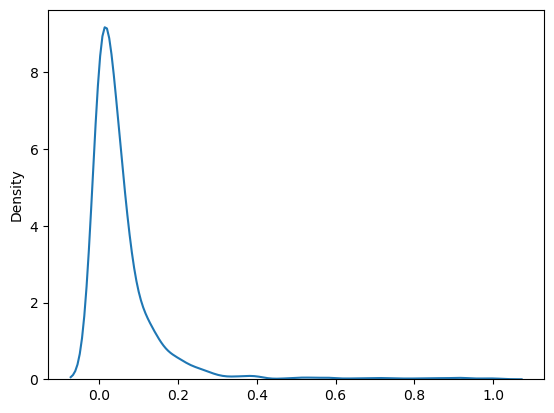

In [54]:
sns.kdeplot(upper_triangular_values)

In [55]:
for i in np.arange(90, 100, 1): 
    print(i, np.percentile(upper_triangular_values, i))

90 0.1412664595450247
91 0.14994590433840074
92 0.16179353040909214
93 0.17621307898662392
94 0.19515290799092866
95 0.2080677762595622
96 0.2348332822514768
97 0.26945664146694587
98 0.3842046594129484
99 0.638969685537649


In [56]:
df = threshold_transform(df, threshold=0.45)
df

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
HMV23/000059/0923/1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMV23/000043/0823/11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HMV23/000043/0823/12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
HMV23/000043/0823/13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HMV23/000043/0823/14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [57]:
df_isp_material.rename(columns={'Task #':'Log Item #'}, inplace=True)
df_isq_material.rename(columns={'Task #':'Log Item #'}, inplace=True)
df_iux_material.rename(columns={'Task #':'Log Item #'}, inplace=True)

In [58]:
task = pd.concat([
    df_isp_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Actual Man Hrs.']],
    df_isq_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Actual Man Hrs.']], 
    df_iux_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Actual Man Hrs.']]], 
    ignore_index=True, axis=0).copy()

In [59]:
task.head()

,Log Item #,Source Task/Discrep. #,Description,Actual Man Hrs.
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. DURING INSPECTION OBERVED LH WING SLATE #01...,4.0
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...,4.0
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...,5.0
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP ...,3.0
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS...",0.0


In [60]:
df.to_csv('Desc_ones_zeros.csv', index=True)

In [61]:
obsv_cluster = dict()

for i in range(df.shape[0]):
    for j in range(i+1, df.shape[1]):
        if df.iloc[i, j] == 1:
            if df.columns[i] in obsv_cluster:
                obsv_cluster[df.columns[i]].append(df.columns[j])
            else:
                obsv_cluster[df.columns[i]] = [df.columns[j]]

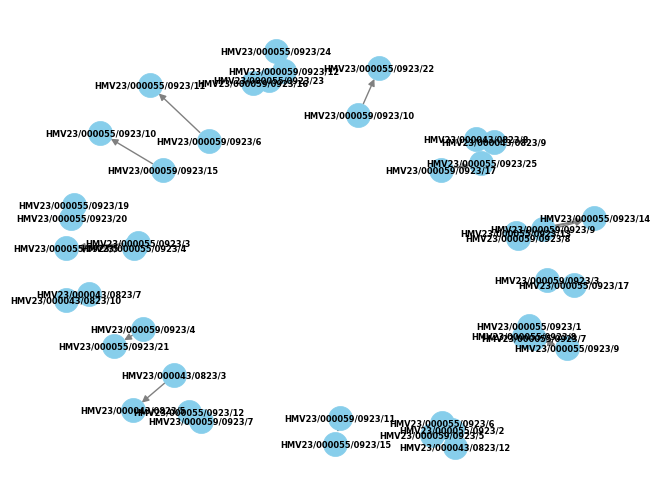

In [62]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on your data
for key, values in obsv_cluster.items():
    G.add_node(key)
    for value in values:
        G.add_edge(key, value)

# Draw the graph
pos = nx.spring_layout(G)  # You can try different layouts based on your preference
nx.draw(G, pos, with_labels=True, font_size=6, node_size=300, node_color="skyblue", font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)

# Show the plot
plt.show()


In [63]:
from pyvis.network import Network

# Create a pyvis network instance
net = Network(height="800px", width="100%", notebook=True, cdn_resources='in_line')

# Add nodes to the network
for key, values in obsv_cluster.items():
    if len(values) > 4:
        net.add_node(key, color='Red')
        for value in values:
            net.add_node(value, color='Red')  
            net.add_edge(key, value)
    else:
        net.add_node(key)
        for value in values:
            net.add_node(value)  
            net.add_edge(key, value)

# Save the interactive graph to an HTML file
net.show("graph_visualization.html")


graph_visualization.html


In [64]:
task_obsv_cluster = dict()
for i in list(obsv_cluster.items()):
    if str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0]) in task_obsv_cluster:
        task_obsv_cluster[str(task[task['Log Item #'] == 
                                   i[0]]['Source Task/Discrep. #'].values.tolist()[0])].append({i[0]:i[1]})
    else:
        task_obsv_cluster[str(task[task['Log Item #'] == 
                                   i[0]]['Source Task/Discrep. #'].values.tolist()[0])] = [{i[0]:i[1]}]   

In [65]:
from pyvis.network import Network


# Create a pyvis network instance
net1 = Network(height="800px", width="100%", notebook=True, cdn_resources='in_line')

# Add nodes and edges to the network
for key, values in task_obsv_cluster.items():
    net1.add_node(key, color="red")
    for edge_dict in values:
        for edge_key, edge_values in edge_dict.items():
            net1.add_node(edge_key)
            net1.add_edge(key, edge_key)
            for edge_value in edge_values:
                net1.add_node(edge_value)
                net1.add_edge(edge_key, edge_value)

# Add a heading to the HTML content
heading_html = "<h1>Task Clusters Graph Visualization</h1>"
net1.html = heading_html + net1.html

# Save the interactive graph to an HTML file
net1.show("task_graph_visualization.html")


task_graph_visualization.html


In [66]:
# Get clusters based on edge relationships between observations i.e, 
# all the observtions that are similar will be in a group. This uses the obsv_cluster dictionary

clusters = {}
for edge in net.edges:
    source = edge['from']
    target = edge['to']

    if source not in clusters:
        clusters[source] = set([source, target])
    else:
        clusters[source].add(target)

# Convert clusters to a dictionary where values are lists
clusters_list = {key: list(value) for key, value in clusters.items()}

# Print clusters as lists
cnt = 0
for key, value in clusters_list.items():
    cnt += 1
    print(f"Group : {value}")

print(f"Total groups : {cnt}")

Group : ['HMV23/000059/0923/3', 'HMV23/000055/0923/17']
Group : ['HMV23/000055/0923/21', 'HMV23/000059/0923/4']
Group : ['HMV23/000055/0923/6', 'HMV23/000059/0923/5']
Group : ['HMV23/000055/0923/11', 'HMV23/000059/0923/6']
Group : ['HMV23/000059/0923/7', 'HMV23/000055/0923/12']
Group : ['HMV23/000059/0923/8', 'HMV23/000055/0923/14', 'HMV23/000055/0923/13', 'HMV23/000059/0923/9']
Group : ['HMV23/000059/0923/9', 'HMV23/000055/0923/14', 'HMV23/000055/0923/13']
Group : ['HMV23/000055/0923/22', 'HMV23/000059/0923/10']
Group : ['HMV23/000055/0923/15', 'HMV23/000059/0923/11']
Group : ['HMV23/000059/0923/12', 'HMV23/000055/0923/24']
Group : ['HMV23/000059/0923/15', 'HMV23/000055/0923/10']
Group : ['HMV23/000055/0923/23', 'HMV23/000059/0923/16']
Group : ['HMV23/000055/0923/25', 'HMV23/000059/0923/17']
Group : ['HMV23/000055/0923/1', 'HMV23/000055/0923/7']
Group : ['HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000055/0923/6']
Group : ['HMV23/000055/0923/3', 'HMV23/000055/0923/5', 'HMV23/

In [67]:
# From the above cells, it is clear that few nodes are repeated in different groups.
# Hence, we will create groups based on these nodes. 
# So, that all observations related directly or indirectly will be in the same group

def create_groups(edges):
    # Create an adjacency list from the edges
    adj_list = {}
    for edge in edges:
        for node in edge:
            adj_list.setdefault(node, set()).update(edge - {node})

    # Function to perform depth-first search (DFS)
    def dfs(node, visited, group):
        visited.add(node)
        group.add(node)
        for neighbor in adj_list.get(node, []):
            if neighbor not in visited:
                dfs(neighbor, visited, group)

    # Initialize variables
    visited = set()
    groups = []

    # Traverse the graph using DFS
    for node in adj_list.keys():
        if node not in visited:
            group = set()
            dfs(node, visited, group)
            groups.append(list(group))

    return groups


source_task_logitems = create_groups(list(clusters.values()))
print(source_task_logitems)


[['HMV23/000059/0923/3', 'HMV23/000055/0923/17'], ['HMV23/000055/0923/21', 'HMV23/000059/0923/4'], ['HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000055/0923/6', 'HMV23/000059/0923/5'], ['HMV23/000059/0923/6', 'HMV23/000055/0923/11'], ['HMV23/000059/0923/7', 'HMV23/000055/0923/12'], ['HMV23/000059/0923/8', 'HMV23/000055/0923/14', 'HMV23/000059/0923/9', 'HMV23/000055/0923/13'], ['HMV23/000055/0923/22', 'HMV23/000059/0923/10'], ['HMV23/000055/0923/15', 'HMV23/000059/0923/11'], ['HMV23/000059/0923/12', 'HMV23/000055/0923/24'], ['HMV23/000059/0923/15', 'HMV23/000055/0923/10'], ['HMV23/000055/0923/23', 'HMV23/000059/0923/16'], ['HMV23/000055/0923/25', 'HMV23/000059/0923/17'], ['HMV23/000055/0923/8', 'HMV23/000055/0923/1', 'HMV23/000055/0923/9', 'HMV23/000055/0923/7'], ['HMV23/000055/0923/3', 'HMV23/000055/0923/5', 'HMV23/000055/0923/4'], ['HMV23/000055/0923/20', 'HMV23/000055/0923/19'], ['HMV23/000043/0823/3', 'HMV23/000043/0823/5'], ['HMV23/000043/0823/7', 'HMV23/000043/0823/10'], 

In [68]:
src_task_groups = []
for i in source_task_logitems:
    temp = []
    for j in i:
        temp.append(task[task['Log Item #'] == j]['Source Task/Discrep. #'].values[0])
    src_task_groups.append(list(set(temp)))  # remove duplicates in temp)
src_task_groups

[['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['215222-01-1 (LH)'],
 ['531900-03-1'],
 ['384241-01-1'],
 ['AWR23/003086/0923', 'AIRCRAFT ARRIVAL INSPECTION'],
 ['WEAR LIMITS- BONDING LEADS'],
 ['252100-01-1'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AWR23/002555/0823'],
 ['AIRCRAFT ARRIVAL INSPECTION']]

In [69]:
src_task_description = []
for i in source_task_logitems:
    temp = []
    for j in i:
        temp.append(task[task['Log Item #'] == j]['Description'].values[0])
    src_task_description.append(temp)
src_task_description

[['DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION : \n1) LH HORZ STAB TYPE A DISCHARGER QTY# 2 & TYPE B DISCHARGER QTY#3 \n2) RH HORZ STAB TYPE A DISCHARGER QTY#1 \n3)VERTICAL STABILISER TYPE A DISCHARGER QTY 01 & TYPE B DISCHARGER QTY 02.',
  'DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION LH WING TIP TRAILING EDGE TYPE B DISCHARGER QTY#1, RH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#1, LH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#3, VERT STAB TYPE A DISCHARGER QTY#1, RUDDER TYPE B DISCHARGER QTY#1.'],
 ['DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP INOP AT FOLLOWING LOCATION\n1. 80VU RH AVIONICS COMPARTMENT FIN: 9LS QTY#1, 90VU FWD AVIONICS COMPARMENT FIN: 6LS QTY#1.\n2. THS COMPARMENT FIN: 5LJ QTY#1.',
  'DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP INOP AT FOLLOWING LOCATION \n1.103VU BATTERY COMPARMENT LAMP FIN: 8LS QTY#1,.\n2. REFUEL/DEFUEL CONTROL PANEL FLOODLIGHT LAMP FIN: 32QU.'],
 ['DURING INSPECTIO

In [70]:
src_task_man_hrs = []
for i in source_task_logitems:
    temp = []
    for j in i:
        temp.append(task[task['Log Item #'] == j]['Actual Man Hrs.'].values[0])
    src_task_man_hrs.append(temp)
src_task_man_hrs

[[5.0, 7.0],
 [3.0, 3.0],
 [2.0, 2.0, 3.0, 0.0],
 [15.0, 15.0],
 [20.0, 20.0],
 [5.0, 5.0, 7.0, 5.0],
 [4.0, 2.0],
 [3.0, 4.0],
 [3.0, 2.5],
 [6.0, 5.0],
 [24.0, 18.0],
 [8.0, 16.0],
 [3.0, 2.0, 7.0, 7.0],
 [2.0, 4.0, 2.5],
 [1.0, 1.0],
 [8.0, 8.0],
 [5.0, 16.0],
 [5.0, 10.0]]

In [71]:
result_dict = {}

# Zip the corresponding elements from three lists
zipped_elements = zip(source_task_logitems, src_task_groups, src_task_description, src_task_man_hrs)

# Iterate over the zipped elements to create the result dictionary
for i, elements in enumerate(zipped_elements, start=1):
    group_key = f'group_{i}'
    result_dict[group_key] = {
        'logItem': elements[0],
        'sourceTask': elements[1],
        'description': elements[2],
        'man_hrs': elements[3]
    }

# Print the resulting dictionary
print(result_dict)

{'group_1': {'logItem': ['HMV23/000059/0923/3', 'HMV23/000055/0923/17'], 'sourceTask': ['AIRCRAFT ARRIVAL INSPECTION'], 'description': ['DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION : \n1) LH HORZ STAB TYPE A DISCHARGER QTY# 2 & TYPE B DISCHARGER QTY#3 \n2) RH HORZ STAB TYPE A DISCHARGER QTY#1 \n3)VERTICAL STABILISER TYPE A DISCHARGER QTY 01 & TYPE B DISCHARGER QTY 02.', 'DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION LH WING TIP TRAILING EDGE TYPE B DISCHARGER QTY#1, RH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#1, LH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#3, VERT STAB TYPE A DISCHARGER QTY#1, RUDDER TYPE B DISCHARGER QTY#1.'], 'man_hrs': [5.0, 7.0]}, 'group_2': {'logItem': ['HMV23/000055/0923/21', 'HMV23/000059/0923/4'], 'sourceTask': ['AIRCRAFT ARRIVAL INSPECTION'], 'description': ['DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP INOP AT FOLLOWING LOCATION\n1. 80VU RH AVIONICS COMPARTMENT FIN: 9LS QTY#1, 9

In [72]:
from prettytable import PrettyTable

# Create a pretty table
table = PrettyTable()
table.field_names = ["Group", "Source Task", "Log Item", "Description", "man_hrs"]

# Populate the table with data
for group, data in result_dict.items():
    table.add_row([group, data['logItem'], data['sourceTask'], data['description'], data['man_hrs']])

# Print the pretty table
print(table)

+----------+------------------------------------------------------------------------------------------------+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [73]:
from prettytable import PrettyTable

# Create a pretty table
table = PrettyTable()
table.field_names = ["Group", "Log Item", "Source Task", "man_hrs"]

# Populate the table with data
for group, data in result_dict.items():
    table.add_row([group, data['logItem'], data['sourceTask'], data['man_hrs']])

# Print the pretty table
print(table)

+----------+------------------------------------------------------------------------------------------------+------------------------------------------------------+----------------------+
|  Group   |                                            Log Item                                            |                     Source Task                      |       man_hrs        |
+----------+------------------------------------------------------------------------------------------------+------------------------------------------------------+----------------------+
| group_1  |                        ['HMV23/000059/0923/3', 'HMV23/000055/0923/17']                         |           ['AIRCRAFT ARRIVAL INSPECTION']            |      [5.0, 7.0]      |
| group_2  |                        ['HMV23/000055/0923/21', 'HMV23/000059/0923/4']                         |           ['AIRCRAFT ARRIVAL INSPECTION']            |      [3.0, 3.0]      |
| group_3  | ['HMV23/000055/0923/2', 'HMV23/000043/0823/12',

In [74]:
final_result = pd.DataFrame(result_dict.values())
final_result.head()

,logItem,sourceTask,description,man_hrs
0,"[HMV23/000059/0923/3, HMV23/000055/0923/17]",[AIRCRAFT ARRIVAL INSPECTION],[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,"[5.0, 7.0]"
1,"[HMV23/000055/0923/21, HMV23/000059/0923/4]",[AIRCRAFT ARRIVAL INSPECTION],[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,"[3.0, 3.0]"
2,"[HMV23/000055/0923/2, HMV23/000043/0823/12, HM...",[AIRCRAFT ARRIVAL INSPECTION],[DURING INSPECTION OBSERVED LH WING SLAT#5 WEA...,"[2.0, 2.0, 3.0, 0.0]"
3,"[HMV23/000059/0923/6, HMV23/000055/0923/11]",[AIRCRAFT ARRIVAL INSPECTION],[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,"[15.0, 15.0]"
4,"[HMV23/000059/0923/7, HMV23/000055/0923/12]",[AIRCRAFT ARRIVAL INSPECTION],[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,"[20.0, 20.0]"


In [75]:
final_result = final_result[['sourceTask', 'logItem', 'description', 'man_hrs']]
final_result.head()

,sourceTask,logItem,description,man_hrs
0,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/3, HMV23/000055/0923/17]",[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,"[5.0, 7.0]"
1,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/21, HMV23/000059/0923/4]",[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,"[3.0, 3.0]"
2,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/2, HMV23/000043/0823/12, HM...",[DURING INSPECTION OBSERVED LH WING SLAT#5 WEA...,"[2.0, 2.0, 3.0, 0.0]"
3,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/6, HMV23/000055/0923/11]",[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,"[15.0, 15.0]"
4,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/7, HMV23/000055/0923/12]",[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,"[20.0, 20.0]"


In [76]:
final_result.to_excel('FinalResults/flight_maintenance_description_result.xlsx', index=False)

# Model

In [77]:
import ast

In [78]:
df_spare_parts = pd.read_excel('FinalResults/spare_parts.xlsx')
df_spare_parts.head()

,logItem,soureceTask,description,man_hrs,spareParts,usedQty
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. DURING INSPECTION OBERVED LH WING SLATE #01...,4.0,"{'BOLT': 1.0, 'ELBOW': 6.0, 'PLATE': 1.0, 'SEA...",12.0
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...,4.0,0,0.0
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...,5.0,{'DISCHRGR': 5.0},5.0
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP ...,3.0,"{'LAMP': 1.0, 'LAMP-GE S-8 28V 643W SC BAYONET...",2.0
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS...",0.0,"{'ELBOW': 2.0, 'SEAL': 2.0}",4.0


In [79]:
description_embeddings.T

,0,1,2,3,4,5,6,7,8,9,...,443,444,445,446,447,448,449,450,451,452
HMV23/000059/0923/1,0.000000,0.0,0.0,0.000000,0.0,0.168266,0.0,0.0,0.00000,0.206335,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.112706,0.000000,0.0,0.000000
HMV23/000059/0923/2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
HMV23/000059/0923/3,0.000000,0.0,0.0,0.000000,0.0,0.092725,0.0,0.0,0.10695,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
HMV23/000059/0923/4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
HMV23/000059/0923/5,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.196448,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMV23/000043/0823/11,0.230108,0.0,0.0,0.272564,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.125691,0.000000,0.0,0.000000
HMV23/000043/0823/12,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.352538,0.0,0.192566,0.000000,0.0,0.000000
HMV23/000043/0823/13,0.000000,0.0,0.0,0.000000,0.0,0.191541,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
HMV23/000043/0823/14,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [80]:
df_spare_parts['spareParts']

0     {'BOLT': 1.0, 'ELBOW': 6.0, 'PLATE': 1.0, 'SEA...
1                                                     0
2                                     {'DISCHRGR': 5.0}
3     {'LAMP': 1.0, 'LAMP-GE S-8 28V 643W SC BAYONET...
4                           {'ELBOW': 2.0, 'SEAL': 2.0}
                            ...                        
57                                                    0
58                                        {'SEAL': 1.0}
59                                                    0
60                                                    0
61                                                    0
Name: spareParts, Length: 62, dtype: object

In [81]:
target_columns = set()
for i in df_spare_parts['spareParts']:
    if len(str(i)) > 1:
        if isinstance(ast.literal_eval(i), dict):
            for j in ast.literal_eval(i):
                target_columns.add(j)
    else:
        pass

In [82]:
target_columns

{'ACCESS DOOR SEALANT',
 'ADHESIVE HYSOL EA9309-3 1 QUART PER KIT BMSÂ 5-109 Type I, Class 1',
 'ADHESIVE TAPE',
 'ALEXIT-FST FILLER 495-14 incl. Hardener 491-14',
 'ALODINE CHROMATING POWDER',
 'Access Door Sealant',
 'BELLOWS',
 'BLIND RIVET',
 'BOLT',
 'BRAID',
 'BUSHING',
 'CABLE',
 'CLAMP',
 'COMPASS LIGHT',
 'CONTACT',
 'CORROSION INHIBITING COMPOUND',
 'CORROSION INHIBITING COMPOUND-SPRAY',
 'DISCHRGR',
 'Demineralized Water.',
 'Disposable Protective Coverall Safety Work Wear 3M 4520 Body Suit',
 'Disposable Protective Coverall Safety Work Wear 3M 4540 Medium Body Suit MAKE(KEELGUARD)',
 'ELBOW',
 'FILTER',
 'FOAM TAPE',
 'Fuel Tank Sealant',
 'GILLFAB 0.496"X60"X144"',
 'HOSE',
 'INSERT ASSY SLEEVE AND PLUG',
 'ISOPROPYL ALCOHOL',
 'JOINT COMPOUND',
 'LAMP',
 'LAMP-GE S-8 28V 643W SC BAYONET',
 'LEAD',
 'Low Density Sealant',
 'METHYL ETHYL KETONE',
 'MOULD RELEASE AGENT',
 'NON AQUEOUS CLEANER-GENERAL',
 'NUT',
 'NUT CLIP',
 'PIN',
 'PLATE',
 'RECEPTCL',
 'SCREW',
 'SEAL',
 '

In [83]:
targets = pd.DataFrame(columns=list(target_columns))
targets

,INSERT ASSY SLEEVE AND PLUG,ACCESS DOOR SEALANT,Access Door Sealant,METHYL ETHYL KETONE,NUT,SEALANT (130 ML),Demineralized Water.,Fuel Tank Sealant,NUT CLIP,FOAM TAPE,...,"GILLFAB 0.496""X60""X144""",DISCHRGR,PLATE,ALEXIT-FST FILLER 495-14 incl. Hardener 491-14,CLAMP,PIN,ISOPROPYL ALCOHOL,SEALANT (310 ML),BOLT,CORROSION INHIBITING COMPOUND-SPRAY


In [84]:
for i in df_spare_parts['spareParts']:
    if isinstance(i, str):
        i = ast.literal_eval(i)
        if isinstance(i, dict):
            new_row = i
            targets = pd.concat([targets, pd.DataFrame([new_row])], ignore_index=True)
    else:
        new_row = dict(zip(targets.columns, np.zeros(len(targets.columns)).tolist()))
        targets = pd.concat([targets, pd.DataFrame([new_row])], ignore_index=True)

In [85]:
targets

,INSERT ASSY SLEEVE AND PLUG,ACCESS DOOR SEALANT,Access Door Sealant,METHYL ETHYL KETONE,NUT,SEALANT (130 ML),Demineralized Water.,Fuel Tank Sealant,NUT CLIP,FOAM TAPE,...,"GILLFAB 0.496""X60""X144""",DISCHRGR,PLATE,ALEXIT-FST FILLER 495-14 incl. Hardener 491-14,CLAMP,PIN,ISOPROPYL ALCOHOL,SEALANT (310 ML),BOLT,CORROSION INHIBITING COMPOUND-SPRAY
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
targets['BOLT']

0     1.0
1     0.0
2     NaN
3     NaN
4     NaN
     ... 
57    0.0
58    NaN
59    0.0
60    0.0
61    0.0
Name: BOLT, Length: 62, dtype: float64

In [87]:
targets.fillna(0, inplace=True)

In [88]:
targets

,INSERT ASSY SLEEVE AND PLUG,ACCESS DOOR SEALANT,Access Door Sealant,METHYL ETHYL KETONE,NUT,SEALANT (130 ML),Demineralized Water.,Fuel Tank Sealant,NUT CLIP,FOAM TAPE,...,"GILLFAB 0.496""X60""X144""",DISCHRGR,PLATE,ALEXIT-FST FILLER 495-14 incl. Hardener 491-14,CLAMP,PIN,ISOPROPYL ALCOHOL,SEALANT (310 ML),BOLT,CORROSION INHIBITING COMPOUND-SPRAY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
input_data = df_spare_parts['soureceTask'].values.tolist()

In [90]:
from sklearn.preprocessing import OneHotEncoder

# Reshape the list to a 2D array, required by OneHotEncoder
input_data = np.array(input_data).reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories='auto')

# Fit and transform the data
input_data = encoder.fit_transform(input_data)

input_data

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 

In [91]:
columns = [f'f_{i}' for i in range(input_data.shape[1])]

input_data = pd.DataFrame(input_data, columns=columns)
input_data

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
59,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
encoder.categories_

[array(['215222-01-1 (LH)', '252100-01-1', '262300-02-1', '353000-07-1',
        '384241-01-1', '531900-03-1', 'AIRCRAFT ARRIVAL INSPECTION',
        'AWR23/002555/0823', 'AWR23/002577/0823', 'AWR23/002877/0923',
        'AWR23/003086/0923', 'AWR23/003125/0923',
        'WEAR LIMITS- BONDING LEADS'], dtype='<U27')]

In [93]:
description_embeddings.T.shape
description_embeddings = description_embeddings.T.copy()

In [94]:
description_embeddings.reset_index(drop=True, inplace=True)

In [95]:
description_embeddings.columns = [f'd_{i}' for i in range(description_embeddings.shape[1])]

In [96]:
data = pd.concat([description_embeddings, input_data], axis=1)
data

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12
0,0.000000,0.0,0.0,0.000000,0.0,0.168266,0.0,0.0,0.00000,0.206335,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.092725,0.0,0.0,0.10695,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.230108,0.0,0.0,0.272564,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
59,0.000000,0.0,0.0,0.000000,0.0,0.191541,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
import numpy as np

# Assuming you have a numpy array 'original_data' with shape (37, 53) for 37 samples and 53 output variables

def generate_bootstrap_sample(data, targets):
    n_samples, n_outputs = data.shape
    
    indices = np.random.choice(n_samples, n_samples, replace=True)
    bootstrap_sample = data.iloc[indices, :]
    bootstrap_sample_targets = targets.iloc[indices, :]
    return bootstrap_sample, bootstrap_sample_targets

# Generate synthetic data using bootstrap
num_bootstrap_samples = 100  # Adjust as needed
synthetic_data = [generate_bootstrap_sample(data, targets)[0] for _ in range(num_bootstrap_samples)]
synthetic_data_targets = [generate_bootstrap_sample(data,targets)[1] for _ in range(num_bootstrap_samples)]

for i in synthetic_data:
    data = pd.concat([data, i], axis=0, ignore_index=True)
for i in synthetic_data_targets:
    targets = pd.concat([targets, i], axis=0, ignore_index=True)

In [98]:
data.shape

(6262, 466)

In [99]:
targets.shape

(6262, 53)

In [100]:
targets

,INSERT ASSY SLEEVE AND PLUG,ACCESS DOOR SEALANT,Access Door Sealant,METHYL ETHYL KETONE,NUT,SEALANT (130 ML),Demineralized Water.,Fuel Tank Sealant,NUT CLIP,FOAM TAPE,...,"GILLFAB 0.496""X60""X144""",DISCHRGR,PLATE,ALEXIT-FST FILLER 495-14 incl. Hardener 491-14,CLAMP,PIN,ISOPROPYL ALCOHOL,SEALANT (310 ML),BOLT,CORROSION INHIBITING COMPOUND-SPRAY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6257,320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,...,154.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
6258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

In [102]:
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.2)

Nonlinear_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize MultiOutputRegressor with the linear regression model
multi_output_model = MultiOutputRegressor(Nonlinear_model)

# Train the multi-output model
multi_output_model.fit(x_train, y_train)

# Predict on the test set
predictions = multi_output_model.predict(x_test)


In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate and print performance metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')


Mean Absolute Error (MAE): 1.077294438161078
Mean Squared Error (MSE): 73.41917852824297
R-squared (R2): -0.01292926716435827


# TESTING ON GROUPS

In [104]:
df = pd.read_excel('FinalResults/man_hrs_prob.xlsx')
df.head()

,sourceTask,logItem,description,frequency_count,man_hrs,frequency,avg_man_hrs,probability
0,['AIRCRAFT ARRIVAL INSPECTION'],"['HMV23/000055/0923/17', 'HMV23/000059/0923/3']",['DURING ARRIVAL INSPECTION FOUND STATIC DISCH...,"[1, 1]","[7.0, 5.0]",0.666667,4.000000,0.666667
1,['AIRCRAFT ARRIVAL INSPECTION'],"['HMV23/000059/0923/4', 'HMV23/000055/0923/21']",['DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAM...,"[1, 1]","[3.0, 3.0]",0.666667,2.000000,0.666667
2,['AIRCRAFT ARRIVAL INSPECTION'],"['HMV23/000059/0923/5', 'HMV23/000043/0823/12'...","['DURING ARRIVAL INSPECTION , OBSERVED FOLLOWI...","[1, 2, 1]","[0.0, 2.0, 2.0, 3.0]",1.333333,2.333333,1.000000
3,['AIRCRAFT ARRIVAL INSPECTION'],"['HMV23/000055/0923/11', 'HMV23/000059/0923/6']",['DURING INSPECTION FOUND FOLLOWING FORWARD CA...,"[1, 1]","[15.0, 15.0]",0.666667,10.000000,0.666667
4,['AIRCRAFT ARRIVAL INSPECTION'],"['HMV23/000055/0923/12', 'HMV23/000059/0923/7']",['DURING INSPECTION FOUND FOLLOWING AFT CARGO ...,"[1, 1]","[20.0, 20.0]",0.666667,13.333333,0.666667


In [105]:
df.tail(2)

,sourceTask,logItem,description,frequency_count,man_hrs,frequency,avg_man_hrs,probability
35,353000-07-1,HMV23/000043/0823/14,DURING DETAILED INSPECTION OF PORTABLE OXYGEN ...,[1],1,0.333333,0.333333,0.333333
36,AIRCRAFT ARRIVAL INSPECTION,HMV23/000043/0823/15,"WRT CDLB ENTRY BOOK#11729,S/N:002 COMPARTMENT ...",[1],1.1,0.333333,0.366667,0.333333


In [106]:
task = []
for i in df['sourceTask'].values:
    if i[0] == '[':
        task.append(ast.literal_eval(i)[0])
    else:
        task.append(i)

description = []
for i in df['description'].values:
    if i[0] == '[':
        description.append(' '.join(ast.literal_eval(i)))
    else:
        description.append(i)
        
test = pd.DataFrame({'task': task, 'description': description})
test.head()

,task,description
0,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...
1,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP ...
2,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS..."
3,AIRCRAFT ARRIVAL INSPECTION,DURING INSPECTION FOUND FOLLOWING FORWARD CARG...
4,AIRCRAFT ARRIVAL INSPECTION,DURING INSPECTION FOUND FOLLOWING AFT CARGO FL...


In [107]:
test.shape

(37, 2)

In [108]:
desc_test_embed = vectorizer.transform(test['description'].tolist())

In [109]:
desc_test_embed = desc_test_embed.toarray()

In [110]:
test['task'].unique().shape

(12,)

In [111]:
task_test_embed = test['task'].values

# Reshape the list to a 2D array, required by OneHotEncoder
task_test_embed = np.array(task_test_embed).reshape(-1, 1)

# # Initialize the OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, categories='auto')

task_test_embed = encoder.transform(task_test_embed)

In [112]:
encoder.categories_

[array(['215222-01-1 (LH)', '252100-01-1', '262300-02-1', '353000-07-1',
        '384241-01-1', '531900-03-1', 'AIRCRAFT ARRIVAL INSPECTION',
        'AWR23/002555/0823', 'AWR23/002577/0823', 'AWR23/002877/0923',
        'AWR23/003086/0923', 'AWR23/003125/0923',
        'WEAR LIMITS- BONDING LEADS'], dtype='<U27')]

In [113]:
task_test_embed

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 

In [114]:
test_results = multi_output_model.predict(np.concatenate((task_test_embed, desc_test_embed), axis=1))

In [115]:
y_test = pd.DataFrame(columns=list(target_columns))
y_test

,INSERT ASSY SLEEVE AND PLUG,ACCESS DOOR SEALANT,Access Door Sealant,METHYL ETHYL KETONE,NUT,SEALANT (130 ML),Demineralized Water.,Fuel Tank Sealant,NUT CLIP,FOAM TAPE,...,"GILLFAB 0.496""X60""X144""",DISCHRGR,PLATE,ALEXIT-FST FILLER 495-14 incl. Hardener 491-14,CLAMP,PIN,ISOPROPYL ALCOHOL,SEALANT (310 ML),BOLT,CORROSION INHIBITING COMPOUND-SPRAY


In [116]:
pd.read_excel('FinalResults/man_spare_results.xlsx').shape

(37, 14)

In [117]:
for i in pd.read_excel('FinalResults/man_spare_results.xlsx')['group_spare_avg']:
    if isinstance(i, str):
        i = ast.literal_eval(i)
        if isinstance(i, dict):
            new_row = i
            y_test = pd.concat([y_test, pd.DataFrame([new_row])], ignore_index=True)
    else:
        new_row = dict(zip(y_test.columns, np.zeros(len(y_test.columns)).tolist()))
        y_test = pd.concat([y_test, pd.DataFrame([new_row])], ignore_index=True)

In [118]:
y_test.fillna(0, inplace=True)

In [119]:
y_test

,INSERT ASSY SLEEVE AND PLUG,ACCESS DOOR SEALANT,Access Door Sealant,METHYL ETHYL KETONE,NUT,SEALANT (130 ML),Demineralized Water.,Fuel Tank Sealant,NUT CLIP,FOAM TAPE,...,"GILLFAB 0.496""X60""X144""",DISCHRGR,PLATE,ALEXIT-FST FILLER 495-14 incl. Hardener 491-14,CLAMP,PIN,ISOPROPYL ALCOHOL,SEALANT (310 ML),BOLT,CORROSION INHIBITING COMPOUND-SPRAY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,32.5,...,154.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0
4,260.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,40.0,27.5,...,150.0,0.0,0.0,3.0,0.0,4.0,4.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
test_results.shape

(37, 53)

In [121]:
# Calculate and print performance metrics
mae = mean_absolute_error(y_test, test_results)
mse = mean_squared_error(y_test, test_results)
r2 = r2_score(y_test, test_results)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Absolute Error (MAE): 1.2069053478991325
Mean Squared Error (MSE): 109.7177057334522
R-squared (R2): -0.00866861828135011


In [125]:
pd.DataFrame(test_results, columns=y_test.columns).to_excel('spare_results.xlsx')